In [120]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import chess.pgn

game_moves_scores_df = pd.read_csv('stockfish.csv')

TRAINING_SET_LENGTH = 25000
TEST_SET_LENGTH = 25000

#TODO - normalize features

In [121]:
game_moves_score_sums = []
for i in game_moves_scores_df.index:
    move_scores_str = game_moves_scores_df['MoveScores'][i]
    # print(f"{move_scores_str}")

    game_move_score_sum = 0
    for move_score in move_scores_str.split():
        if (move_score != "NA"):
            game_move_score_sum = game_move_score_sum + int(move_score)
    # print(game_move_score_sum)
    game_moves_score_sums.append([game_move_score_sum])
    
print(game_moves_score_sums)
print(len(game_moves_score_sums))
game_scores_sums_np = np.array(game_moves_score_sums)
# print(temp)
training_game_scores_sums_df = pd.DataFrame(game_scores_sums_np[:TRAINING_SET_LENGTH], columns=['White Game Score'])
test_game_scores_sums_df = pd.DataFrame(game_scores_sums_np[TEST_SET_LENGTH:], columns=['White Game Score'])
print(training_game_scores_sums_df.head())
print(test_game_scores_sums_df.head())

[[910], [450], [-73373], [3792], [14996], [1788], [17808], [-137350], [9730], [8203], [19031], [-23968], [-9048], [6216], [-1121], [2163], [20054], [-51034], [-11958], [-9918], [8386], [-13048], [109466], [12276], [-18967], [780], [61820], [401], [12464], [1284], [5276], [-4763], [72049], [532], [4544], [-27042], [142173], [7467], [185681], [2012], [-11855], [5530], [5572], [221], [368], [-15974], [2157], [-13114], [470], [-12840], [5162], [-21282], [11470], [-36840], [-4428], [1647], [-26787], [18772], [-6136], [-20004], [40865], [41091], [33094], [-15705], [7270], [6273], [887], [12370], [1391], [-14994], [375], [29068], [1752], [1022], [10067], [460], [-5491], [-1806], [12198], [22562], [-3209], [144], [10405], [-15362], [-19280], [3455], [19361], [109500], [10965], [13204], [6289], [1138], [-6831], [-17747], [-12003], [100527], [16007], [-1582], [-5401], [263], [-24166], [-3637], [40124], [11895], [-5491], [544], [37061], [14605], [-11232], [6472], [1601], [7429], [284], [690], [88

In [122]:
chess_games = open("data.pgn")

training_games_data = []
for i in range(TRAINING_SET_LENGTH):
    print(f"Parsing game #{i+1} of {TRAINING_SET_LENGTH}", end="\r")
    game = chess.pgn.read_game(chess_games)

    game_number = int(game.headers["Event"])
    white_elo = int(game.headers['WhiteElo'])
    black_elo = int(game.headers['BlackElo'])
    result = game.headers['Result']
    training_games_data.append([game_number, white_elo, black_elo, result])

print("\n")
test_games_data = []
for i in range(TEST_SET_LENGTH):
    print(f"Parsing game #{i+1} of {TEST_SET_LENGTH}", end="\r")
    game = chess.pgn.read_game(chess_games)

    game_number = int(game.headers["Event"])
    result = game.headers['Result']
    test_games_data.append([game_number, result])

Parsing game #25000 of 25000



In [123]:
# print(training_games_data[:10])
training_data_np = np.array(training_games_data, dtype=object)
# print(training_data_np)

test_data_np = np.array(test_games_data, dtype=object)
# print(test_data_np)

training_data = pd.DataFrame(training_data_np, columns=['Event ID', 'White Elo', 'Black Elo', 'Result'])
test_data = pd.DataFrame(test_data_np, columns=['Event ID', 'Result'])
print(training_data.head())
print(test_data.head())

  Event ID White Elo Black Elo   Result
0        1      2354      2411  1/2-1/2
1        2      2523      2460  1/2-1/2
2        3      1915      1999      0-1
3        4      2446      2191      1-0
4        5      2168      2075      1-0
  Event ID   Result
0    25001  1/2-1/2
1    25002      0-1
2    25003      1-0
3    25004  1/2-1/2
4    25005  1/2-1/2


In [124]:
training_data_one_hot = pd.get_dummies(training_data['Result']).astype(int)
training_data_one_hot.rename(columns={'0-1': 'Black Won', '1-0': 'White Won', '1/2-1/2': 'Draw'}, inplace=True)
# print(training_data_one_hot)

# print(training_data.head())
training_data_new = training_data.drop("Result", axis=1)
# print(training_data_new.head())
training_data_new_new = pd.concat([training_data_new, training_game_scores_sums_df, training_data_one_hot], axis=1)
print(training_data_new_new.head())
training_data = training_data_new_new


  Event ID White Elo Black Elo  White Game Score  Black Won  White Won  Draw
0        1      2354      2411               910          0          0     1
1        2      2523      2460               450          0          0     1
2        3      1915      1999            -73373          1          0     0
3        4      2446      2191              3792          0          1     0
4        5      2168      2075             14996          0          1     0


In [127]:
training_features = training_data[["White Game Score", "Black Won", "White Won", "Draw"]]
training_labels = training_data["White Elo"]
print(training_features)
print(training_labels)

x_train, x_validation, y_train, y_validation = train_test_split(training_features, training_labels, train_size=0.8, test_size=0.2, random_state=6)
print(x_train.shape)
print(x_validation.shape)
 
print(y_train.shape)
print(y_validation.shape)


       White Game Score  Black Won  White Won  Draw
0                   910          0          0     1
1                   450          0          0     1
2                -73373          1          0     0
3                  3792          0          1     0
4                 14996          0          1     0
...                 ...        ...        ...   ...
24995              -437          1          0     0
24996             -8003          1          0     0
24997              7637          0          1     0
24998             10078          0          1     0
24999             -7444          1          0     0

[25000 rows x 4 columns]
0        2354
1        2523
2        1915
3        2446
4        2168
         ... 
24995    1844
24996    2391
24997    2634
24998    2319
24999    1717
Name: White Elo, Length: 25000, dtype: object
(20000, 4)
(5000, 4)
(20000,)
(5000,)


In [128]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(x_train, y_train)

y_predicted = linear_regression_model.predict(x_validation)

print("Training score:")
print(linear_regression_model.score(x_train, y_train))

print("Test score:")
print(linear_regression_model.score(x_validation, y_validation))

Training score:
0.07978168610517944
Test score:
0.06589662503818161


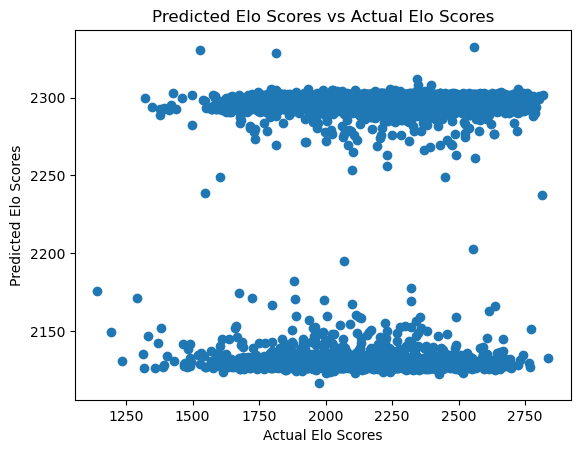

In [130]:
import matplotlib.pyplot as plt

plt.scatter(y_validation, y_predicted)
plt.xlabel("Actual Elo Scores")
plt.ylabel("Predicted Elo Scores")
plt.title("Predicted Elo Scores vs Actual Elo Scores")
plt.show()

0          910
1          450
2       -73373
3         3792
4        14996
         ...  
24995     -437
24996    -8003
24997     7637
24998    10078
24999    -7444
Length: 25000, dtype: int32
<class 'pandas.core.series.Series'>


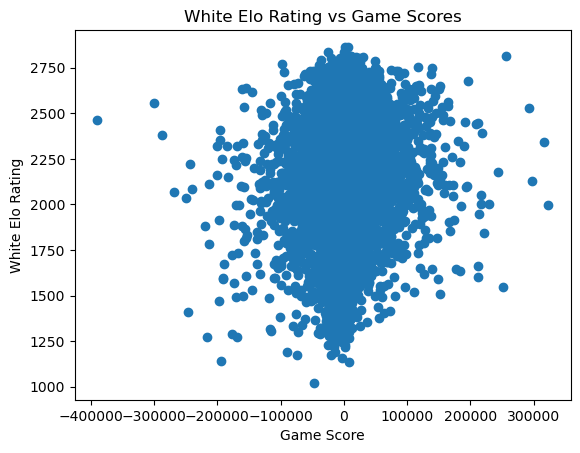

In [139]:

temp = game_scores_sums_np.flatten()
training_game_scores_sums_series = pd.Series(temp[:TRAINING_SET_LENGTH])
print(training_game_scores_sums_series)

print(type(training_labels))



plt.scatter(training_game_scores_sums_series, training_labels)
plt.xlabel("Game Score")
plt.ylabel("White Elo Rating")
plt.title("White Elo Rating vs Game Scores")
plt.show()